# Contrôle optimal d'une pandémie par apprentissage par renforcement tabulaire

**Modèle SEIRD** — Résolution par **Q-Learning**, **SARSA** et **DP approchée** sur état réduit $(S, E, I)$ discrétisé.

L'environnement simule la dynamique SEIRD complète (voir `model.py`), mais l'agent observe uniquement $(S, E, I)$ discrétisé en bins non-uniformes. Les compartiments $R$ et $D$ n'influencent pas la dynamique utile ni les coûts.

**Contrôles :**
- $u_{conf} \in \{0, 0.25, 0.5, 0.75, 1\}$ — niveau de confinement
- $u_{vacc} \in \{0, 0.25, 0.5, 0.75, 1\}$ — intensité de vaccination (×max_vacc_rate)

→ 25 actions discrètes.

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from model import SEIREnv, ProblemConfig, SocioEconomicConfig

plt.rcParams.update({
    "figure.figsize": (14, 5),
    "axes.grid": True,
    "font.size": 11,
})

config = ProblemConfig()
print(f"Paramètres épidémiologiques : β={config.beta}, σ={config.sigma}, γ={config.gamma}, μ={config.mu}")
print(f"R₀ = β/γ = {config.beta / config.gamma:.2f}")
print(f"Horizon = {config.max_steps} jours, dt = {config.dt}")
print(f"\nCoûts (normalisés C_eco=1) :")
c = config.socio_eco_config
print(f"  C_eco={c.confinement_eco_cost}, C_vacc={c.vaccination_eco_cost}, "
      f"C_vie={c.life_cost}, C_hosp={c.infection_cost}")

Paramètres épidémiologiques : β=0.27, σ=0.14, γ=0.1, μ=0.01
R₀ = β/γ = 2.70
Horizon = 365 jours, dt = 1.0

Coûts (normalisés C_eco=1) :
  C_eco=1.0, C_vacc=0.005, C_vie=1000.0, C_hosp=3.0


## 1. Discrétisation de l'espace d'états et d'actions

**État réduit :** On ne garde que $(S, E, I)$ car les équations de transition de $S$, $E$, $I$ ne dépendent ni de $R$ ni de $D$. C'est Markovien pour la partie utile à la décision.

**Bins non-uniformes :** Plus fins près de 0 pour $E$ et $I$ (là où se jouent les transitions critiques).

- $S$ : 11 bins — $[0, 0.4, 0.6, 0.7, 0.8, 0.85, 0.9, 0.93, 0.95, 0.97, 0.985, 1.001]$
- $E, I$ : 11 bins — $[0, 10^{-5}, 3{\times}10^{-5}, 10^{-4}, 3{\times}10^{-4}, 10^{-3}, 3{\times}10^{-3}, 10^{-2}, 3{\times}10^{-2}, 0.1, 0.3, 1.001]$

→ $11^3 = 1331$ états possibles (en pratique moins car $S+E+I \leq 1$).

**Actions :** Grille $5 \times 5$ → 25 actions discrètes.

In [2]:
# ═══════════════════════════════════════════════════════════════
#  Discrétisation SEI + grille d'actions
# ═══════════════════════════════════════════════════════════════

S_bins = np.array([0, 0.4, 0.6, 0.7, 0.8, 0.85, 0.9, 0.93, 0.95, 0.97, 0.985, 1.001])
E_bins = np.array([0, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3, 1.001])
I_bins = E_bins.copy()

nS = len(S_bins) - 1  # 11
nE = len(E_bins) - 1  # 11
nI = len(I_bins) - 1  # 11
n_states = nS * nE * nI
print(f"Nombre d'états discrétisés : {nS}×{nE}×{nI} = {n_states}")


def bin_index(x: float, bins: np.ndarray) -> int:
    """Retourne l'indice du bin contenant x (0-indexé)."""
    return int(np.clip(np.digitize([x], bins)[0] - 1, 0, len(bins) - 2))


def state_to_id(obs: np.ndarray) -> int:
    """Convertit une observation [S, E, I, ...] en un indice entier."""
    iS = bin_index(float(obs[0]), S_bins)
    iE = bin_index(float(obs[1]), E_bins)
    iI = bin_index(float(obs[2]), I_bins)
    return (iS * nE + iE) * nI + iI


# Grille d'actions : 5 niveaux × 2 contrôles → 25 actions
grid_vals = np.array([0.0, 0.25, 0.5, 0.75, 1.0], dtype=np.float32)
actions = np.array([(uc, uv) for uc in grid_vals for uv in grid_vals], dtype=np.float32)
n_actions = len(actions)
print(f"Nombre d'actions discrètes : {n_actions}")
print(f"Exemples d'actions : {actions[:5].tolist()} ...")

Nombre d'états discrétisés : 11×11×11 = 1331
Nombre d'actions discrètes : 25
Exemples d'actions : [[0.0, 0.0], [0.0, 0.25], [0.0, 0.5], [0.0, 0.75], [0.0, 1.0]] ...


In [3]:
# ═══════════════════════════════════════════════════════════════
#  Fonctions utilitaires : simulation & enregistrement
# ═══════════════════════════════════════════════════════════════

def run_episode(env, policy_fn, record=True):
    """
    Simule un épisode complet en utilisant policy_fn(obs) → action continue [u_conf, u_vacc].
    Retourne le reward total et optionnellement l'historique complet.
    """
    obs, _ = env.reset()
    done = False
    total_reward = 0.0
    history = {
        "S": [], "E": [], "I": [], "R": [], "D": [],
        "u_conf": [], "u_vacc": [],
        "reward": [],
        "L_eco": [], "L_vacc": [], "L_deaths": [], "L_infection": [],
    }

    while not done:
        action = policy_fn(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if record:
            history["S"].append(obs[0])
            history["E"].append(obs[1])
            history["I"].append(obs[2])
            history["R"].append(obs[3])
            history["D"].append(obs[4])
            history["u_conf"].append(float(action[0]))
            history["u_vacc"].append(float(action[1]))
            history["reward"].append(reward)
            history["L_eco"].append(info.get("L_eco", 0))
            history["L_vacc"].append(info.get("L_vacc", 0))
            history["L_deaths"].append(info.get("L_deaths", 0))
            history["L_infection"].append(info.get("L_infection", 0))

    if record:
        for k in history:
            history[k] = np.array(history[k])
    return total_reward, history


def tabular_policy_fn(Q_table, actions_grid):
    """Fabrique une policy_fn greedy à partir d'une Q-table."""
    def _policy(obs):
        s = state_to_id(obs)
        a_idx = int(np.argmax(Q_table[s]))
        return actions_grid[a_idx]
    return _policy

print("Fonctions utilitaires chargées ✓")

Fonctions utilitaires chargées ✓


## 2. Q-Learning (off-policy, ε-greedy)

Mise à jour classique :
$$Q(s,a) \leftarrow Q(s,a) + \alpha \Big( r + \gamma \max_{a'} Q(s',a') - Q(s,a) \Big)$$

avec décroissance exponentielle de $\varepsilon$ (exploration → exploitation).

In [4]:
# ═══════════════════════════════════════════════════════════════
#  Q-Learning tabulaire
# ═══════════════════════════════════════════════════════════════

env = SEIREnv(config)
Q_ql = np.zeros((n_states, n_actions), dtype=np.float64)

alpha_ql = 0.1
gamma_ql = 0.99
eps_start, eps_end = 1.0, 0.05
n_episodes_ql = 5000

rng = np.random.default_rng(42)
rewards_ql = []

for ep in range(n_episodes_ql):
    obs, _ = env.reset()
    s = state_to_id(obs)

    eps = eps_end + (eps_start - eps_end) * np.exp(-ep / 1000)
    done = False
    ep_reward = 0.0

    while not done:
        # ε-greedy
        if rng.random() < eps:
            a = rng.integers(n_actions)
        else:
            a = int(np.argmax(Q_ql[s]))

        obs2, r, terminated, truncated, _ = env.step(actions[a])
        s2 = state_to_id(obs2)

        # Mise à jour Q-learning (off-policy : max sur s')
        Q_ql[s, a] += alpha_ql * (r + gamma_ql * np.max(Q_ql[s2]) - Q_ql[s, a])

        s = s2
        ep_reward += r
        done = terminated or truncated

    rewards_ql.append(ep_reward)

    if (ep + 1) % 1000 == 0:
        mean_r = np.mean(rewards_ql[-200:])
        print(f"Q-Learning — épisode {ep+1}/{n_episodes_ql}, ε={eps:.3f}, "
              f"reward moyen (200 derniers) = {mean_r:.1f}")

print(f"\nQ-Learning terminé. Reward final moyen = {np.mean(rewards_ql[-200:]):.1f}")

Q-Learning — épisode 1000/5000, ε=0.400, reward moyen (200 derniers) = -62.9
Q-Learning — épisode 2000/5000, ε=0.179, reward moyen (200 derniers) = -48.8
Q-Learning — épisode 3000/5000, ε=0.097, reward moyen (200 derniers) = -43.7
Q-Learning — épisode 4000/5000, ε=0.067, reward moyen (200 derniers) = -38.7
Q-Learning — épisode 5000/5000, ε=0.056, reward moyen (200 derniers) = -38.6

Q-Learning terminé. Reward final moyen = -38.6


## 3. SARSA (on-policy, ε-greedy)

Mise à jour :
$$Q(s,a) \leftarrow Q(s,a) + \alpha \Big( r + \gamma \, Q(s',a') - Q(s,a) \Big)$$

Contrairement au Q-Learning, SARSA utilise l'action $a'$ **effectivement choisie** (pas le max). Cela rend l'algorithme plus conservateur — il tient compte de l'exploration résiduelle.

In [5]:
# ═══════════════════════════════════════════════════════════════
#  SARSA tabulaire (on-policy)
# ═══════════════════════════════════════════════════════════════

Q_sarsa = np.zeros((n_states, n_actions), dtype=np.float64)

alpha_s = 0.1
gamma_s = 0.99
n_episodes_sarsa = 5000

rewards_sarsa = []

for ep in range(n_episodes_sarsa):
    obs, _ = env.reset()
    s = state_to_id(obs)

    eps = eps_end + (eps_start - eps_end) * np.exp(-ep / 1000)

    # Choisir a₀
    if rng.random() < eps:
        a = rng.integers(n_actions)
    else:
        a = int(np.argmax(Q_sarsa[s]))

    done = False
    ep_reward = 0.0

    while not done:
        obs2, r, terminated, truncated, _ = env.step(actions[a])
        s2 = state_to_id(obs2)

        # Choisir a' ε-greedy (on-policy)
        if rng.random() < eps:
            a2 = rng.integers(n_actions)
        else:
            a2 = int(np.argmax(Q_sarsa[s2]))

        # Mise à jour SARSA (on-policy : utilise Q(s', a'))
        Q_sarsa[s, a] += alpha_s * (r + gamma_s * Q_sarsa[s2, a2] - Q_sarsa[s, a])

        s = s2
        a = a2
        ep_reward += r
        done = terminated or truncated

    rewards_sarsa.append(ep_reward)

    if (ep + 1) % 1000 == 0:
        mean_r = np.mean(rewards_sarsa[-200:])
        print(f"SARSA — épisode {ep+1}/{n_episodes_sarsa}, ε={eps:.3f}, "
              f"reward moyen (200 derniers) = {mean_r:.1f}")

print(f"\nSARSA terminé. Reward final moyen = {np.mean(rewards_sarsa[-200:]):.1f}")

SARSA — épisode 1000/5000, ε=0.400, reward moyen (200 derniers) = -70.8
SARSA — épisode 2000/5000, ε=0.179, reward moyen (200 derniers) = -51.5
SARSA — épisode 3000/5000, ε=0.097, reward moyen (200 derniers) = -48.2
SARSA — épisode 4000/5000, ε=0.067, reward moyen (200 derniers) = -42.1
SARSA — épisode 5000/5000, ε=0.056, reward moyen (200 derniers) = -48.8

SARSA terminé. Reward final moyen = -48.8


## 4. Courbes d'apprentissage Q-Learning vs SARSA

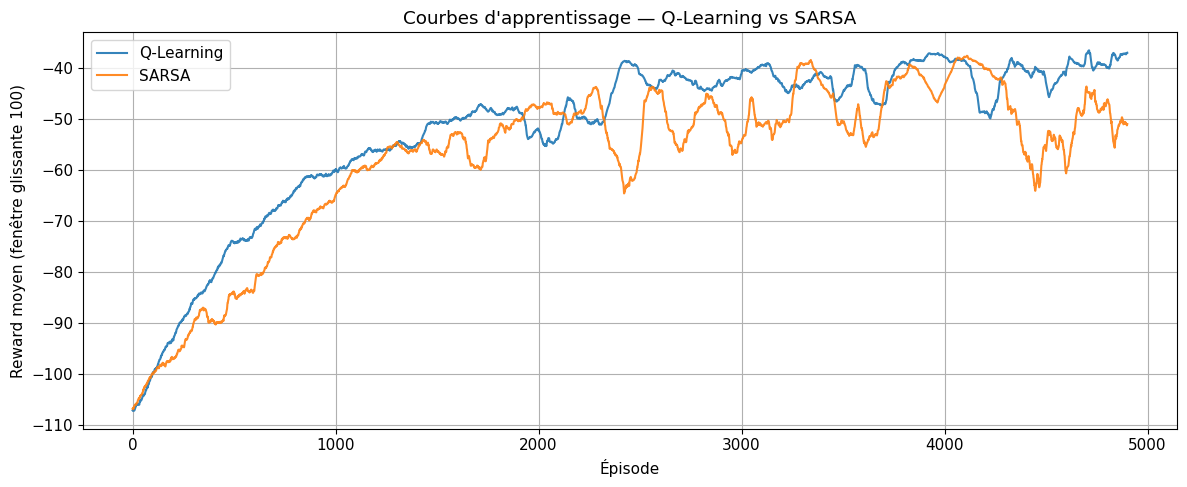

In [6]:
# ═══════════════════════════════════════════════════════════════
#  Courbes d'apprentissage (reward moyen glissant)
# ═══════════════════════════════════════════════════════════════

window = 100

def smooth(x, w=window):
    return np.convolve(x, np.ones(w)/w, mode="valid")

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(smooth(rewards_ql), label="Q-Learning", alpha=0.9)
ax.plot(smooth(rewards_sarsa), label="SARSA", alpha=0.9)
ax.set_xlabel("Épisode")
ax.set_ylabel(f"Reward moyen (fenêtre glissante {window})")
ax.set_title("Courbes d'apprentissage — Q-Learning vs SARSA")
ax.legend()
plt.tight_layout()
plt.show()

## 5. DP approchée (Value Iteration backward, horizon fini)

Pour chaque pas de temps $t = T, T{-}1, \ldots, 1$, on approxime :
$$V_t(s) = \max_a \Big( \hat{\mathbb{E}}[r(s,a,S')] + \gamma \, \hat{\mathbb{E}}[V_{t+1}(S')] \Big)$$

L'espérance est estimée par $K$ simulations Monte-Carlo depuis un état représentatif du bin $s$. C'est de la **DP approchée** car l'espace d'état continu est discrétisé et les transitions sont estimées empiriquement.

In [ ]:
from tqdm.auto import tqdm
# ═══════════════════════════════════════════════════════════════
#  DP approchée — Value Iteration backward (horizon fini)
#  Version optimisée : on réutilise un seul env, et on réduit K
# ═══════════════════════════════════════════════════════════════

T = config.max_steps  # 365
K = 3                 # MC samples par (s, a) — réduit pour la tractabilité
gamma_dp = 0.99

# État représentatif (milieu du bin)
def bin_center(bins, idx):
    return 0.5 * (bins[idx] + bins[idx + 1])

# Tables de valeurs et politique : V[t, s], pi[t, s]
V_dp = np.zeros((T + 1, n_states), dtype=np.float64)
pi_dp = np.zeros((T, n_states), dtype=np.int32)

# États plausibles (S+E+I ≤ 1.05)
plausible = []
for iS in range(nS):
    for iE in range(nE):
        for iI in range(nI):
            s_val = bin_center(S_bins, iS)
            e_val = bin_center(E_bins, iE)
            i_val = bin_center(I_bins, iI)
            if s_val + e_val + i_val <= 1.05:
                sid = (iS * nE + iE) * nI + iI
                plausible.append((sid, s_val, e_val, i_val))

print(f"États plausibles : {len(plausible)} / {n_states}")

# Réutiliser un seul objet env pour éviter le coût de construction
env_dp_single = SEIREnv(config)

# Backward induction
for t in tqdm(range(T - 1, -1, -1), desc="DP backward"):
    for sid, s_val, e_val, i_val in plausible:
        best_val = -np.inf
        best_a = 0

        for a_idx in range(n_actions):
            total_r = 0.0
            total_v_next = 0.0

            for _ in range(K):
                # Reset sans recréer l'objet
                r_val = max(0, 1.0 - s_val - e_val - i_val)
                env_dp_single.state = np.array(
                    [s_val, e_val, i_val, r_val, 0.0], dtype=np.float32
                )
                env_dp_single.current_step = t

                obs2, r, _, _, _ = env_dp_single.step(actions[a_idx])
                s2 = state_to_id(obs2)

                total_r += r
                total_v_next += V_dp[t + 1, s2]

            mean_r = total_r / K
            mean_v = total_v_next / K
            q_val = mean_r + gamma_dp * mean_v

            if q_val > best_val:
                best_val = q_val
                best_a = a_idx

        V_dp[t, sid] = best_val
        pi_dp[t, sid] = best_a

    if (T - t) % 73 == 0:
        print(f"DP backward : t={t} / {T}")

print("DP approchée terminée ✓")

États plausibles : 978 / 1331


KeyboardInterrupt: 

## 6. Heuristiques de référence (baselines)

Pour évaluer nos agents RL et DP, on les compare à des politiques simples :

1. **Aucun contrôle** : $u_{conf}=0$, $u_{vacc}=0$ (laissez-faire)
2. **Vaccination max** : $u_{conf}=0$, $u_{vacc}=1$ (vaccination à plein régime, pas de confinement)
3. **Confinement seuil** : confiner fort quand $I > 2\%$, vacciner à 50%
4. **Double seuil adaptatif** : confinement modulé + vaccination décroissante avec $S$

In [8]:
# ═══════════════════════════════════════════════════════════════
#  Définition des heuristiques
# ═══════════════════════════════════════════════════════════════

def policy_no_control(obs):
    """Aucun contrôle."""
    return np.array([0.0, 0.0], dtype=np.float32)

def policy_vacc_max(obs):
    """Vaccination max, pas de confinement."""
    return np.array([0.0, 1.0], dtype=np.float32)

def policy_seuil_conf(obs):
    """Confinement fort si I > 2%, vaccination à 50%."""
    I = float(obs[2])
    u_conf = 1.0 if I > 0.02 else 0.0
    return np.array([u_conf, 0.5], dtype=np.float32)

def policy_double_seuil(obs):
    """Double seuil adaptatif."""
    S, E, I = float(obs[0]), float(obs[1]), float(obs[2])
    # Confinement modulé
    if I > 0.02:
        u_conf = 0.75
    elif I > 0.005:
        u_conf = 0.25
    else:
        u_conf = 0.0
    # Vaccination : forte quand S est grand (beaucoup de gens à protéger)
    u_vacc = min(1.0, S) if S > 0.3 else 0.25
    return np.array([u_conf, u_vacc], dtype=np.float32)

# Politique DP (time-dependent)
def policy_dp(obs, env_ref=None):
    """Politique DP approchée (dépend du step courant)."""
    s = state_to_id(obs)
    t = min(env_ref.current_step, T - 1) if env_ref else 0
    a_idx = pi_dp[t, s]
    return actions[a_idx]

print("Heuristiques définies ✓")

Heuristiques définies ✓


## 7. Évaluation comparative — Trajectoires et coûts

On simule un épisode complet avec chaque politique et on compare :
- Évolution $(S, E, I, R, D)$
- Actions ($u_{conf}$, $u_{vacc}$)
- Coûts cumulés par composante

In [9]:
# ═══════════════════════════════════════════════════════════════
#  Évaluation de toutes les politiques
# ═══════════════════════════════════════════════════════════════

env_eval = SEIREnv(config)
results = {}

# --- Heuristiques ---
for name, pol_fn in [
    ("Aucun contrôle", policy_no_control),
    ("Vaccination max", policy_vacc_max),
    ("Seuil confinement", policy_seuil_conf),
    ("Double seuil", policy_double_seuil),
]:
    r, h = run_episode(env_eval, pol_fn)
    results[name] = h
    print(f"{name:25s} → reward total = {r:10.1f}")

# --- Q-Learning greedy ---
r, h = run_episode(env_eval, tabular_policy_fn(Q_ql, actions))
results["Q-Learning"] = h
print(f"{'Q-Learning':25s} → reward total = {r:10.1f}")

# --- SARSA greedy ---
r, h = run_episode(env_eval, tabular_policy_fn(Q_sarsa, actions))
results["SARSA"] = h
print(f"{'SARSA':25s} → reward total = {r:10.1f}")

# --- DP approchée ---
env_dp_eval = SEIREnv(config)
obs_dp, _ = env_dp_eval.reset()
done_dp = False
h_dp = {k: [] for k in ["S","E","I","R","D","u_conf","u_vacc","reward",
                          "L_eco","L_vacc","L_deaths","L_infection"]}
total_r_dp = 0.0
while not done_dp:
    action_dp = policy_dp(obs_dp, env_dp_eval)
    obs_dp, r_dp, term_dp, trunc_dp, info_dp = env_dp_eval.step(action_dp)
    done_dp = term_dp or trunc_dp
    total_r_dp += r_dp
    h_dp["S"].append(obs_dp[0]); h_dp["E"].append(obs_dp[1])
    h_dp["I"].append(obs_dp[2]); h_dp["R"].append(obs_dp[3])
    h_dp["D"].append(obs_dp[4])
    h_dp["u_conf"].append(float(action_dp[0]))
    h_dp["u_vacc"].append(float(action_dp[1]))
    h_dp["reward"].append(r_dp)
    h_dp["L_eco"].append(info_dp.get("L_eco",0))
    h_dp["L_vacc"].append(info_dp.get("L_vacc",0))
    h_dp["L_deaths"].append(info_dp.get("L_deaths",0))
    h_dp["L_infection"].append(info_dp.get("L_infection",0))

for k in h_dp:
    h_dp[k] = np.array(h_dp[k])
results["DP approchée"] = h_dp
print(f"{'DP approchée':25s} → reward total = {total_r_dp:10.1f}")

Aucun contrôle            → reward total =      -26.9
Vaccination max           → reward total =      -17.9
Seuil confinement         → reward total =      -77.1
Double seuil              → reward total =      -45.3
Q-Learning                → reward total =      -31.3
SARSA                     → reward total =      -43.0
DP approchée              → reward total =      -26.9


### 7a. Évolution de la population (S, E, I, R, D) — toutes politiques

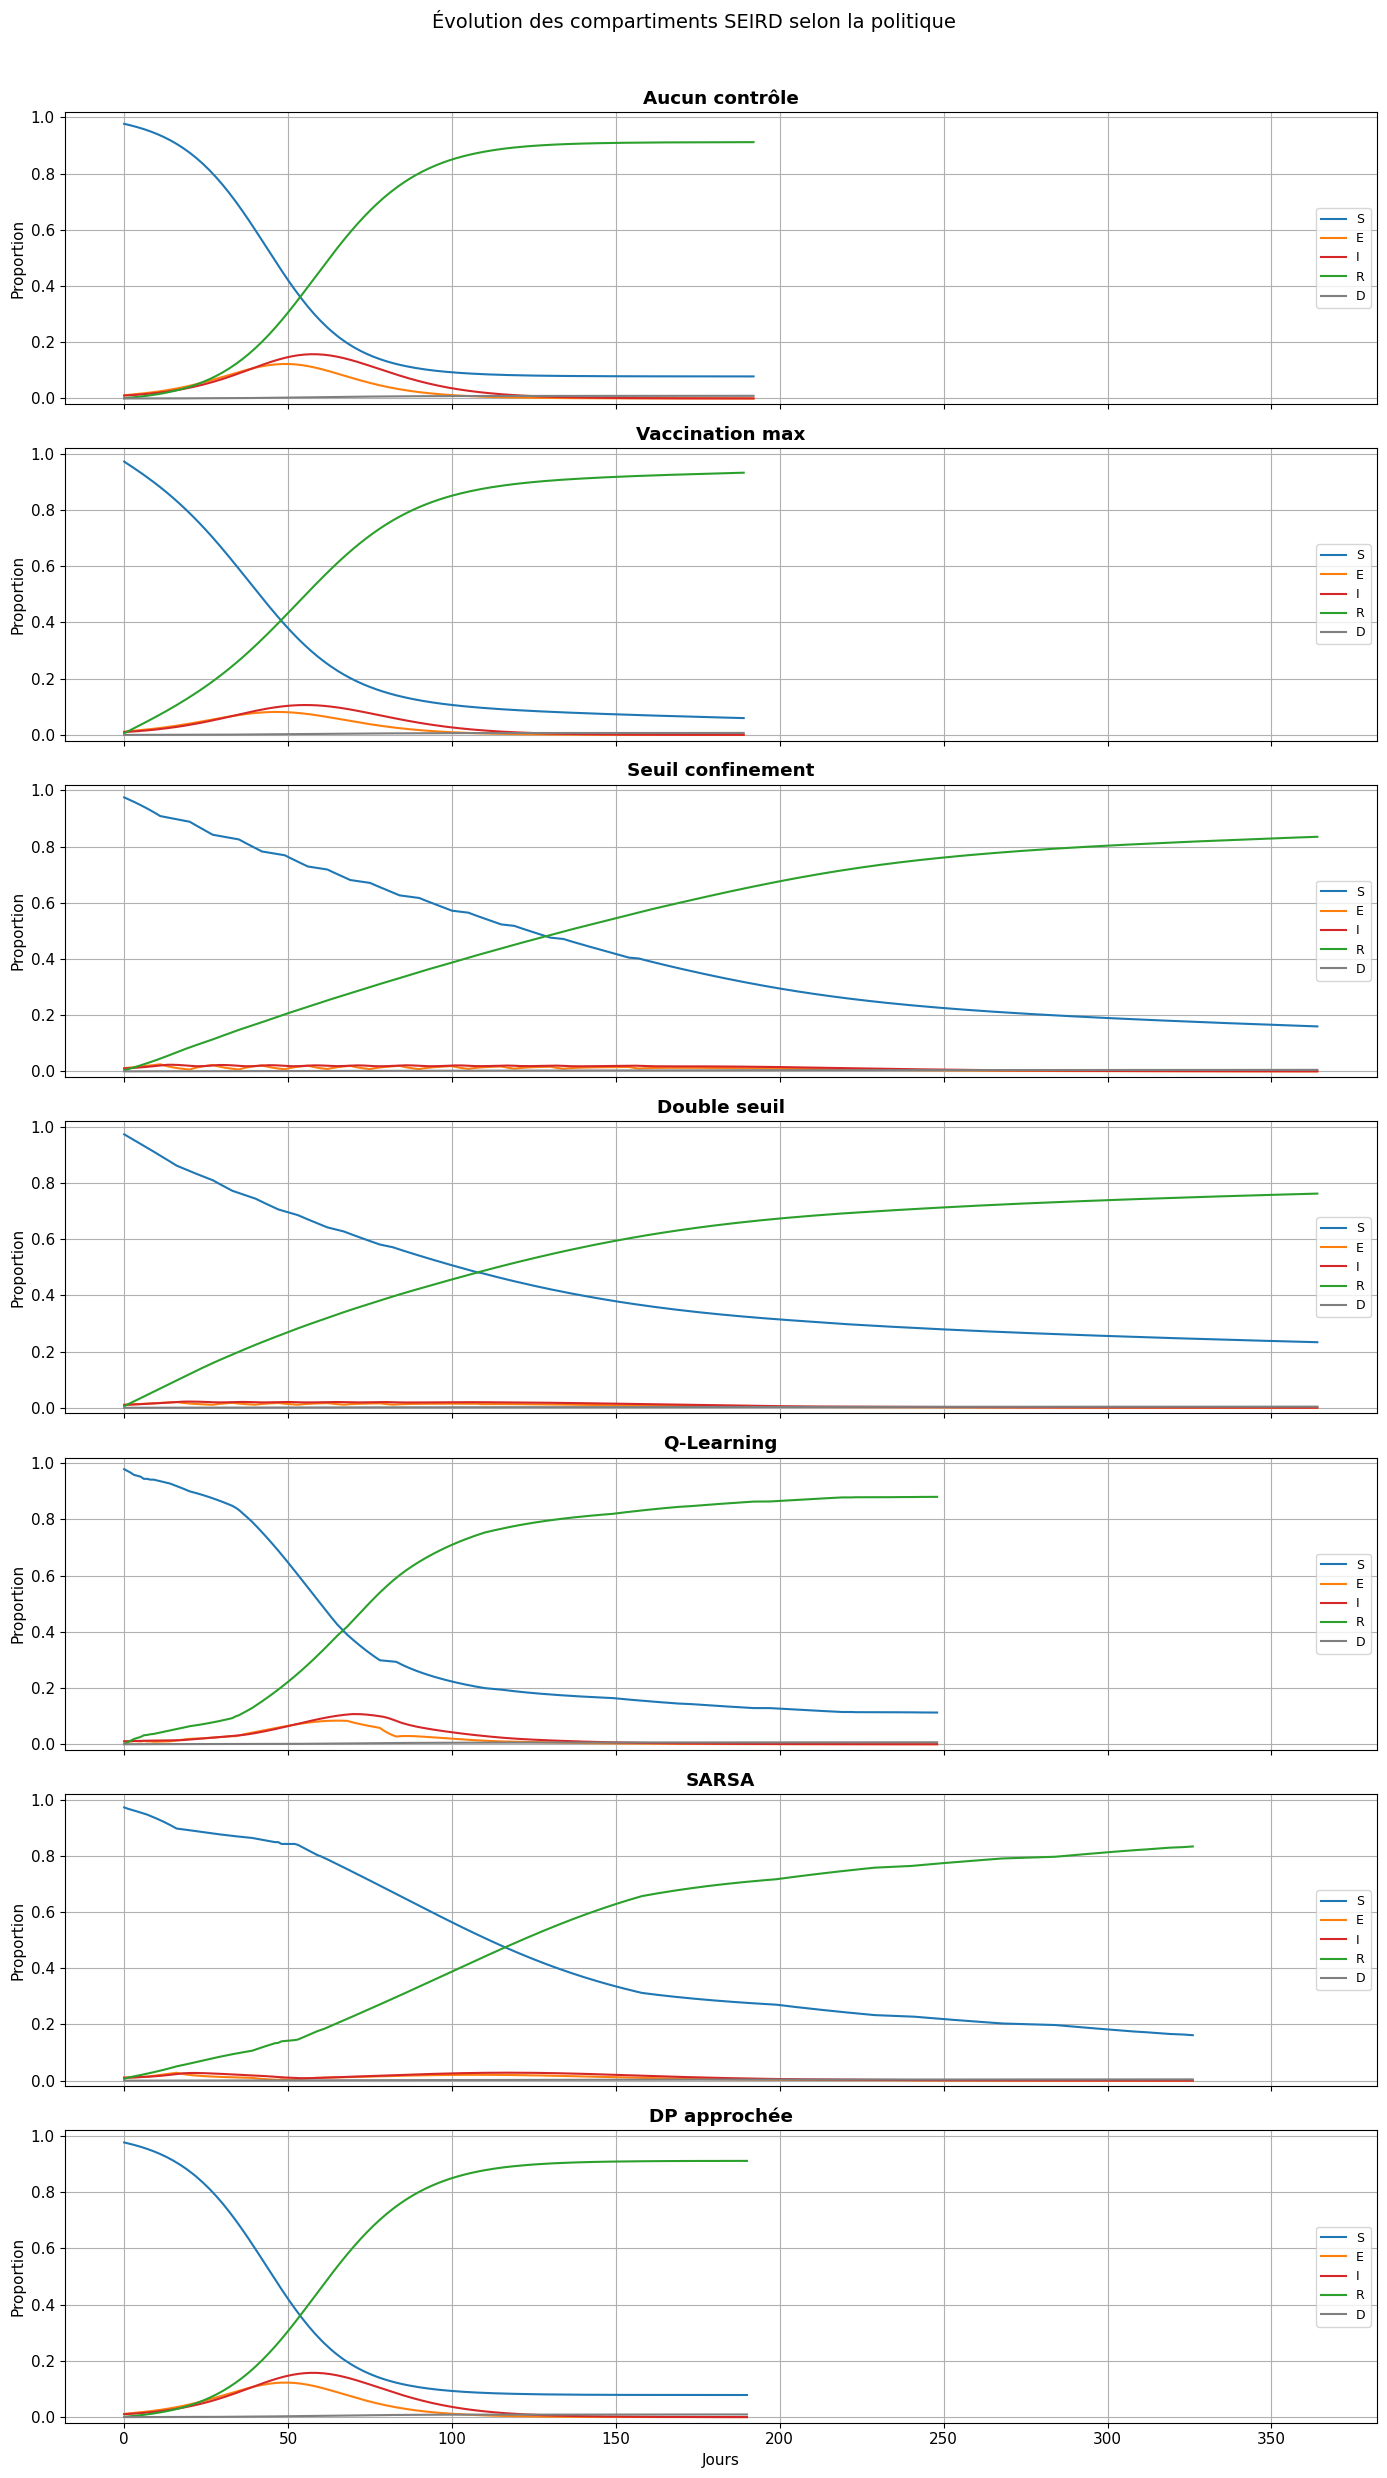

In [10]:
# ═══════════════════════════════════════════════════════════════
#  Plot : Évolution des compartiments SEIRD par politique
# ═══════════════════════════════════════════════════════════════

policy_names = list(results.keys())
n_pol = len(policy_names)
compartments = ["S", "E", "I", "R", "D"]
colors_comp = {"S": "tab:blue", "E": "tab:orange", "I": "tab:red", "R": "tab:green", "D": "tab:gray"}

fig, axes = plt.subplots(n_pol, 1, figsize=(14, 3.5 * n_pol), sharex=True)

for i, name in enumerate(policy_names):
    ax = axes[i]
    h = results[name]
    days = np.arange(len(h["S"]))
    for c in compartments:
        ax.plot(days, h[c], label=c, color=colors_comp[c], linewidth=1.5)
    ax.set_ylabel("Proportion")
    ax.set_title(name, fontweight="bold")
    ax.legend(loc="center right", fontsize=9)
    ax.set_ylim(-0.02, 1.02)

axes[-1].set_xlabel("Jours")
fig.suptitle("Évolution des compartiments SEIRD selon la politique", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### 7b. Commandes appliquées ($u_{conf}$, $u_{vacc}$) au cours du temps

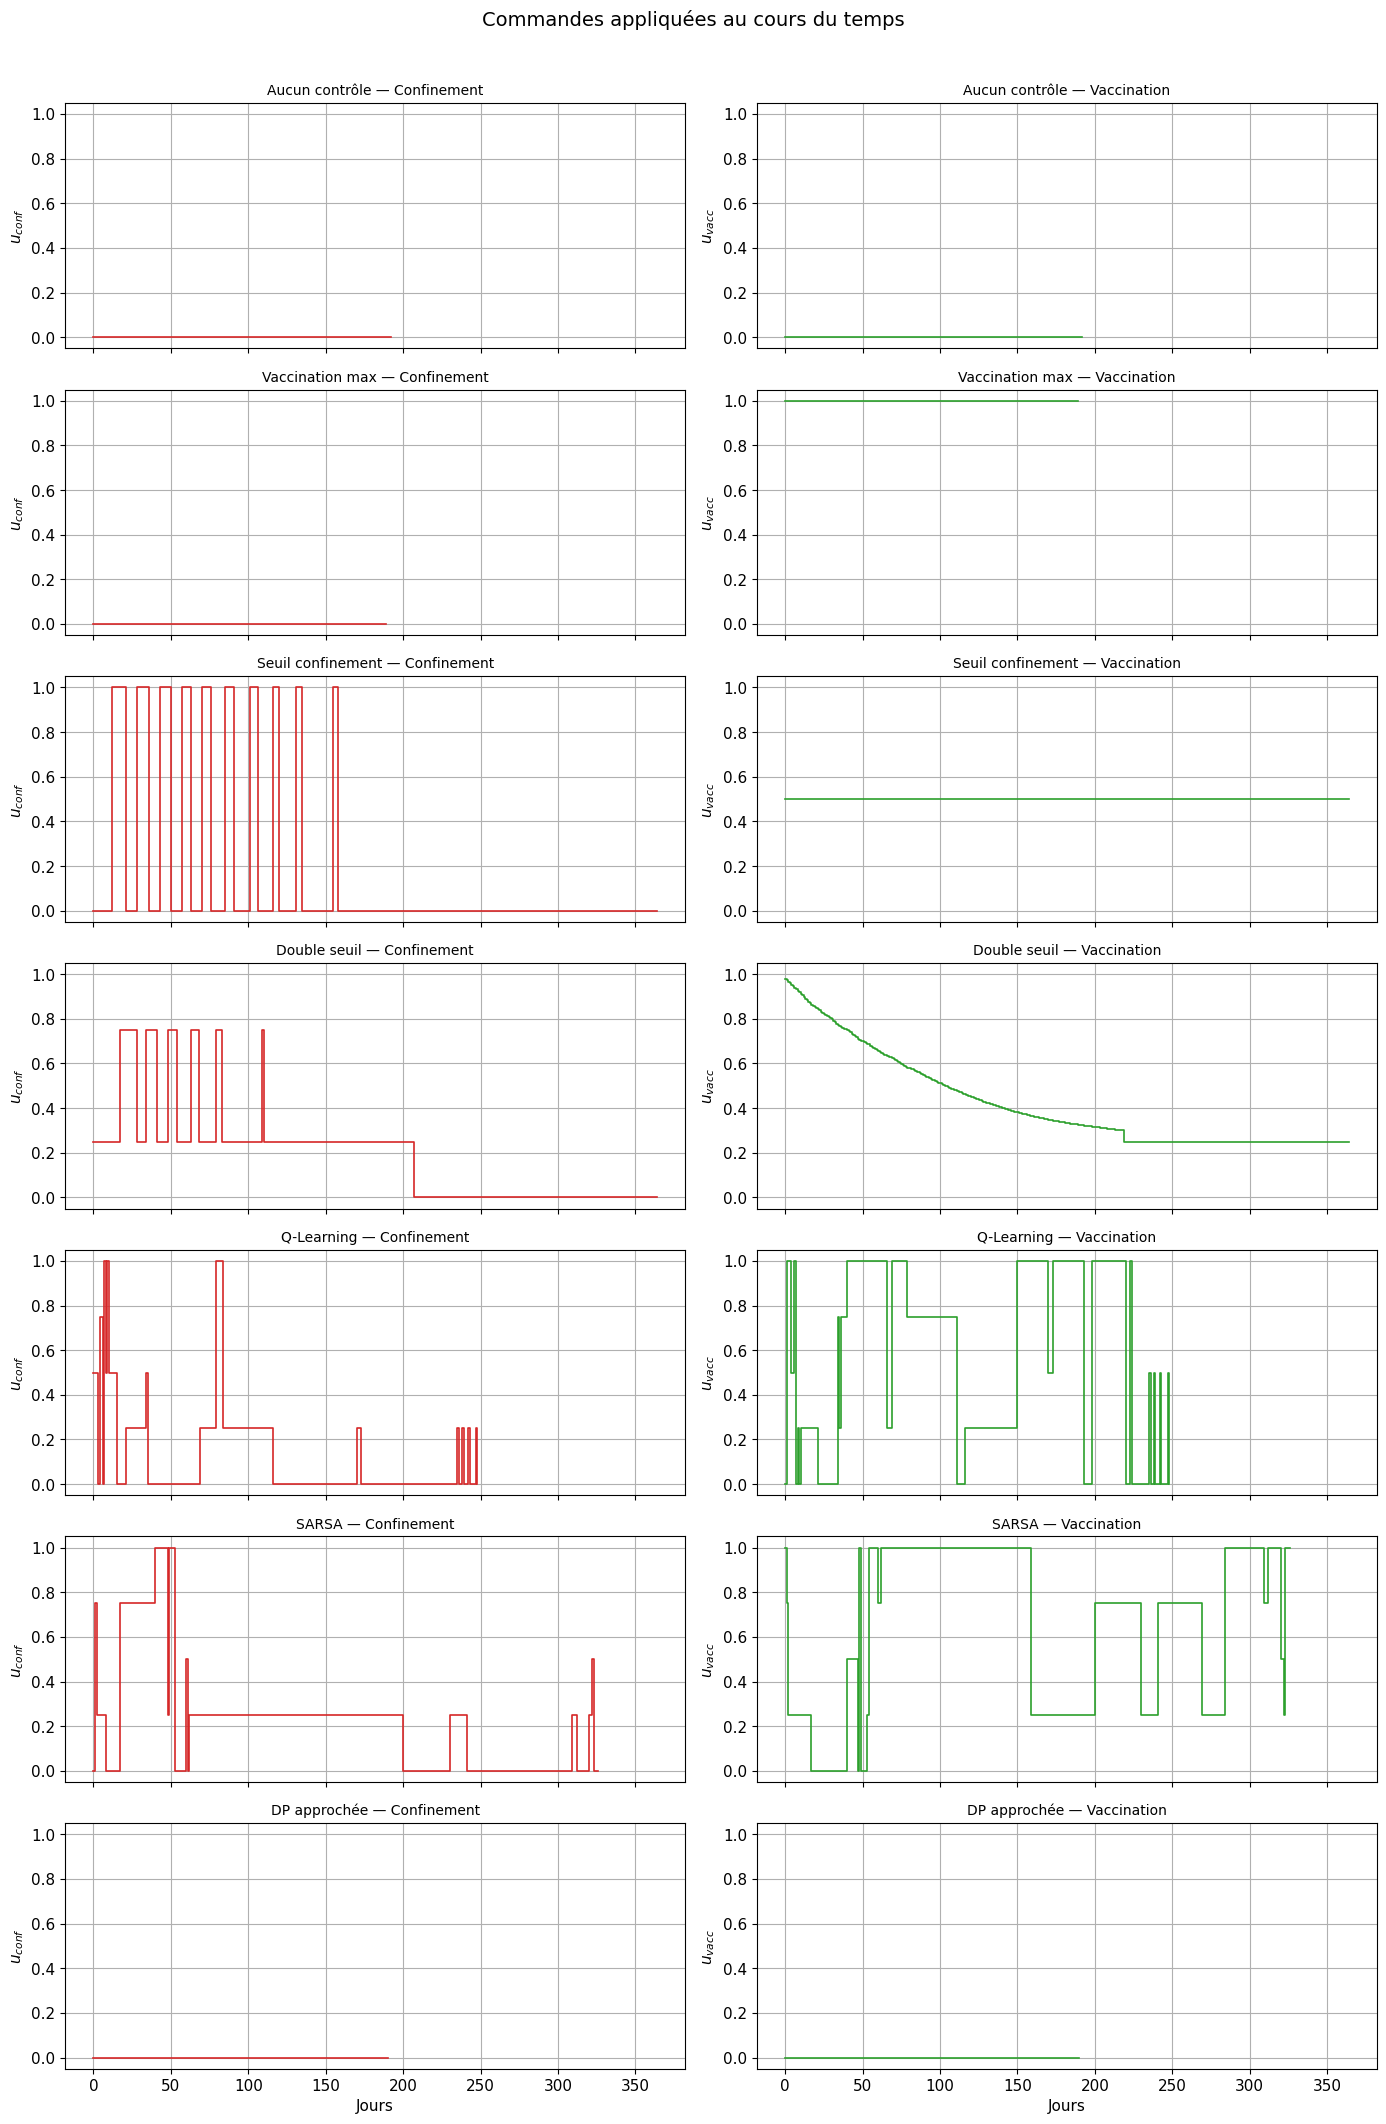

In [11]:
# ═══════════════════════════════════════════════════════════════
#  Plot : Actions u_conf et u_vacc par politique
# ═══════════════════════════════════════════════════════════════

fig, axes = plt.subplots(n_pol, 2, figsize=(14, 3 * n_pol), sharex=True)

for i, name in enumerate(policy_names):
    h = results[name]
    days = np.arange(len(h["u_conf"]))

    # u_conf
    axes[i, 0].step(days, h["u_conf"], where="post", color="tab:red", linewidth=1.2)
    axes[i, 0].set_ylabel("$u_{conf}$")
    axes[i, 0].set_ylim(-0.05, 1.05)
    axes[i, 0].set_title(f"{name} — Confinement", fontsize=10)

    # u_vacc
    axes[i, 1].step(days, h["u_vacc"], where="post", color="tab:green", linewidth=1.2)
    axes[i, 1].set_ylabel("$u_{vacc}$")
    axes[i, 1].set_ylim(-0.05, 1.05)
    axes[i, 1].set_title(f"{name} — Vaccination", fontsize=10)

axes[-1, 0].set_xlabel("Jours")
axes[-1, 1].set_xlabel("Jours")
fig.suptitle("Commandes appliquées au cours du temps", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### 7c. Comparaison de la courbe épidémique (I) et des décès (D)

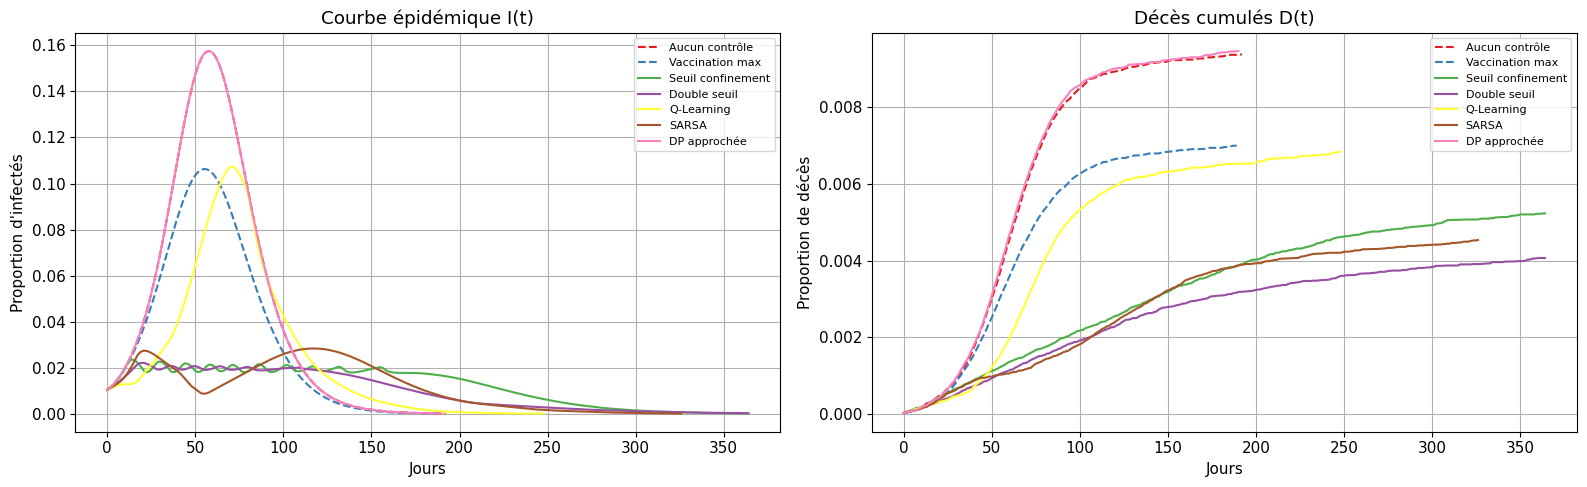

In [12]:
# ═══════════════════════════════════════════════════════════════
#  Plot : Comparaison I(t) et D(t) entre toutes les politiques
# ═══════════════════════════════════════════════════════════════

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

cmap = plt.cm.Set1
for i, name in enumerate(policy_names):
    h = results[name]
    days = np.arange(len(h["I"]))
    ls = "--" if name in ["Aucun contrôle", "Vaccination max"] else "-"
    ax1.plot(days, h["I"], label=name, color=cmap(i / n_pol), linestyle=ls, linewidth=1.5)
    ax2.plot(days, h["D"], label=name, color=cmap(i / n_pol), linestyle=ls, linewidth=1.5)

ax1.set_title("Courbe épidémique I(t)")
ax1.set_xlabel("Jours"); ax1.set_ylabel("Proportion d'infectés")
ax1.legend(fontsize=8)

ax2.set_title("Décès cumulés D(t)")
ax2.set_xlabel("Jours"); ax2.set_ylabel("Proportion de décès")
ax2.legend(fontsize=8)

plt.tight_layout()
plt.show()

### 7d. Coûts cumulés par composante ($\mathcal{L}_{eco}$, $\mathcal{L}_{vacc}$, $\mathcal{L}_{deaths}$, $\mathcal{L}_{hosp}$)

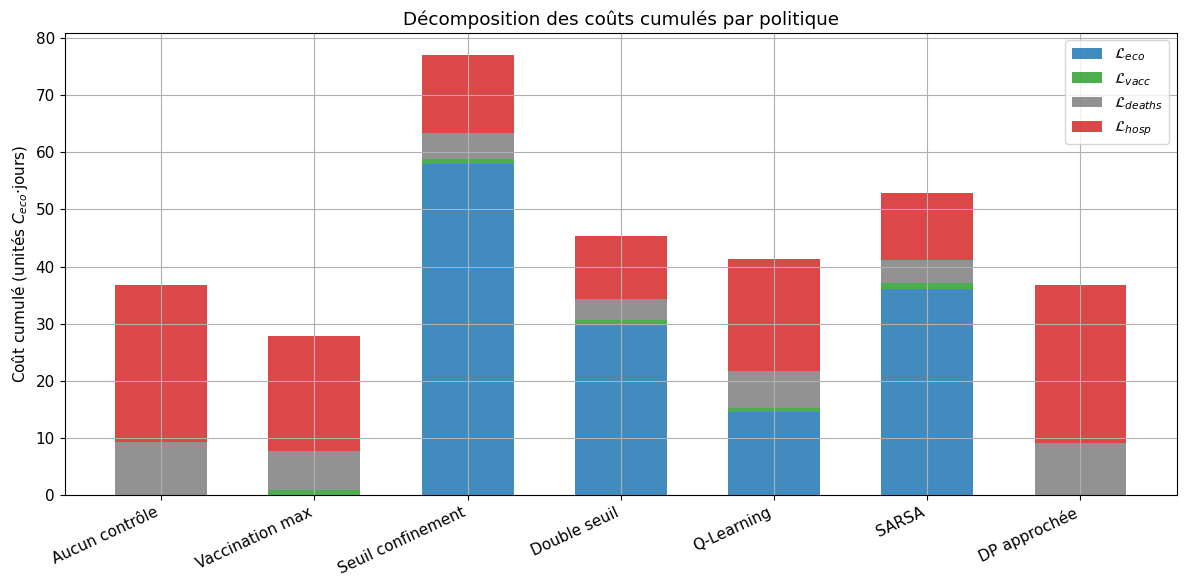


Politique                 |      L_eco |     L_vacc |   L_deaths |     L_hosp |      TOTAL
-------------------------------------------------------------------------------------
Aucun contrôle            |        0.0 |        0.0 |        9.2 |       27.6 |       36.9
Vaccination max           |        0.0 |        0.9 |        6.7 |       20.2 |       27.9
Seuil confinement         |       58.0 |        0.9 |        4.5 |       13.6 |       77.1
Double seuil              |       29.9 |        0.8 |        3.7 |       11.0 |       45.3
Q-Learning                |       14.5 |        0.7 |        6.5 |       19.5 |       41.3
SARSA                     |       36.1 |        1.1 |        4.0 |       11.9 |       53.0
DP approchée              |        0.0 |        0.0 |        9.2 |       27.6 |       36.9


In [13]:
# ═══════════════════════════════════════════════════════════════
#  Plot : Coûts cumulés par composante (barres empilées)
# ═══════════════════════════════════════════════════════════════

cost_keys = ["L_eco", "L_vacc", "L_deaths", "L_infection"]
cost_labels = ["$\\mathcal{L}_{eco}$", "$\\mathcal{L}_{vacc}$",
               "$\\mathcal{L}_{deaths}$", "$\\mathcal{L}_{hosp}$"]
cost_colors = ["tab:blue", "tab:green", "tab:gray", "tab:red"]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(n_pol)
width = 0.6
bottoms = np.zeros(n_pol)

cost_totals = {name: {} for name in policy_names}

for j, (ck, cl, cc) in enumerate(zip(cost_keys, cost_labels, cost_colors)):
    vals = []
    for name in policy_names:
        cum = float(np.sum(results[name][ck]))
        vals.append(cum)
        cost_totals[name][cl] = cum
    vals = np.array(vals)
    ax.bar(x, vals, width, bottom=bottoms, label=cl, color=cc, alpha=0.85)
    bottoms += vals

ax.set_xticks(x)
ax.set_xticklabels(policy_names, rotation=25, ha="right")
ax.set_ylabel("Coût cumulé (unités $C_{eco}$·jours)")
ax.set_title("Décomposition des coûts cumulés par politique")
ax.legend()
plt.tight_layout()
plt.show()

# Tableau récapitulatif
print(f"\n{'Politique':25s} | {'L_eco':>10s} | {'L_vacc':>10s} | {'L_deaths':>10s} | {'L_hosp':>10s} | {'TOTAL':>10s}")
print("-" * 85)
for name in policy_names:
    h = results[name]
    le = np.sum(h["L_eco"]); lv = np.sum(h["L_vacc"])
    ld = np.sum(h["L_deaths"]); li = np.sum(h["L_infection"])
    print(f"{name:25s} | {le:10.1f} | {lv:10.1f} | {ld:10.1f} | {li:10.1f} | {le+lv+ld+li:10.1f}")

## 8. Étude de sensibilité ($C_{vacc}$, $C_{hosp}$)

On ré-entraîne Q-Learning avec des multiplicateurs ×0.5, ×1, ×2 sur $C_{vacc}$ et $C_{hosp}$ pour observer l'impact sur la politique optimale.

In [14]:
# ═══════════════════════════════════════════════════════════════
#  Sensibilité : Q-Learning rapide avec différents C_vacc, C_hosp
# ═══════════════════════════════════════════════════════════════

multipliers = [0.5, 1.0, 2.0]
sensitivity_results = {}

for m_vacc in multipliers:
    for m_hosp in multipliers:
        label = f"C_vacc×{m_vacc}, C_hosp×{m_hosp}"
        print(f"Entraînement {label} ...", end=" ")

        sec = SocioEconomicConfig(
            vaccination_eco_cost=0.005 * m_vacc,
            infection_cost=3.0 * m_hosp,
        )
        cfg_sens = ProblemConfig(socio_eco_config=sec)
        env_sens = SEIREnv(cfg_sens)

        Q_sens = np.zeros((n_states, n_actions), dtype=np.float64)
        n_ep_sens = 2000

        for ep in range(n_ep_sens):
            obs, _ = env_sens.reset()
            s = state_to_id(obs)
            eps = eps_end + (eps_start - eps_end) * np.exp(-ep / 500)
            done = False
            while not done:
                if rng.random() < eps:
                    a = rng.integers(n_actions)
                else:
                    a = int(np.argmax(Q_sens[s]))
                obs2, r, terminated, truncated, _ = env_sens.step(actions[a])
                s2 = state_to_id(obs2)
                Q_sens[s, a] += 0.1 * (r + 0.99 * np.max(Q_sens[s2]) - Q_sens[s, a])
                s = s2
                done = terminated or truncated

        # Évaluer
        env_eval_sens = SEIREnv(cfg_sens)
        r_sens, h_sens = run_episode(env_eval_sens, tabular_policy_fn(Q_sens, actions))
        sensitivity_results[label] = h_sens
        print(f"reward = {r_sens:.1f}")

print("\nÉtude de sensibilité terminée ✓")

Entraînement C_vacc×0.5, C_hosp×0.5 ... reward = -14.3
Entraînement C_vacc×0.5, C_hosp×1.0 ... reward = -39.4
Entraînement C_vacc×0.5, C_hosp×2.0 ... reward = -57.2
Entraînement C_vacc×1.0, C_hosp×0.5 ... reward = -25.4
Entraînement C_vacc×1.0, C_hosp×1.0 ... reward = -58.7
Entraînement C_vacc×1.0, C_hosp×2.0 ... reward = -64.9
Entraînement C_vacc×2.0, C_hosp×0.5 ... reward = -21.3
Entraînement C_vacc×2.0, C_hosp×1.0 ... reward = -36.9
Entraînement C_vacc×2.0, C_hosp×2.0 ... reward = -75.0

Étude de sensibilité terminée ✓


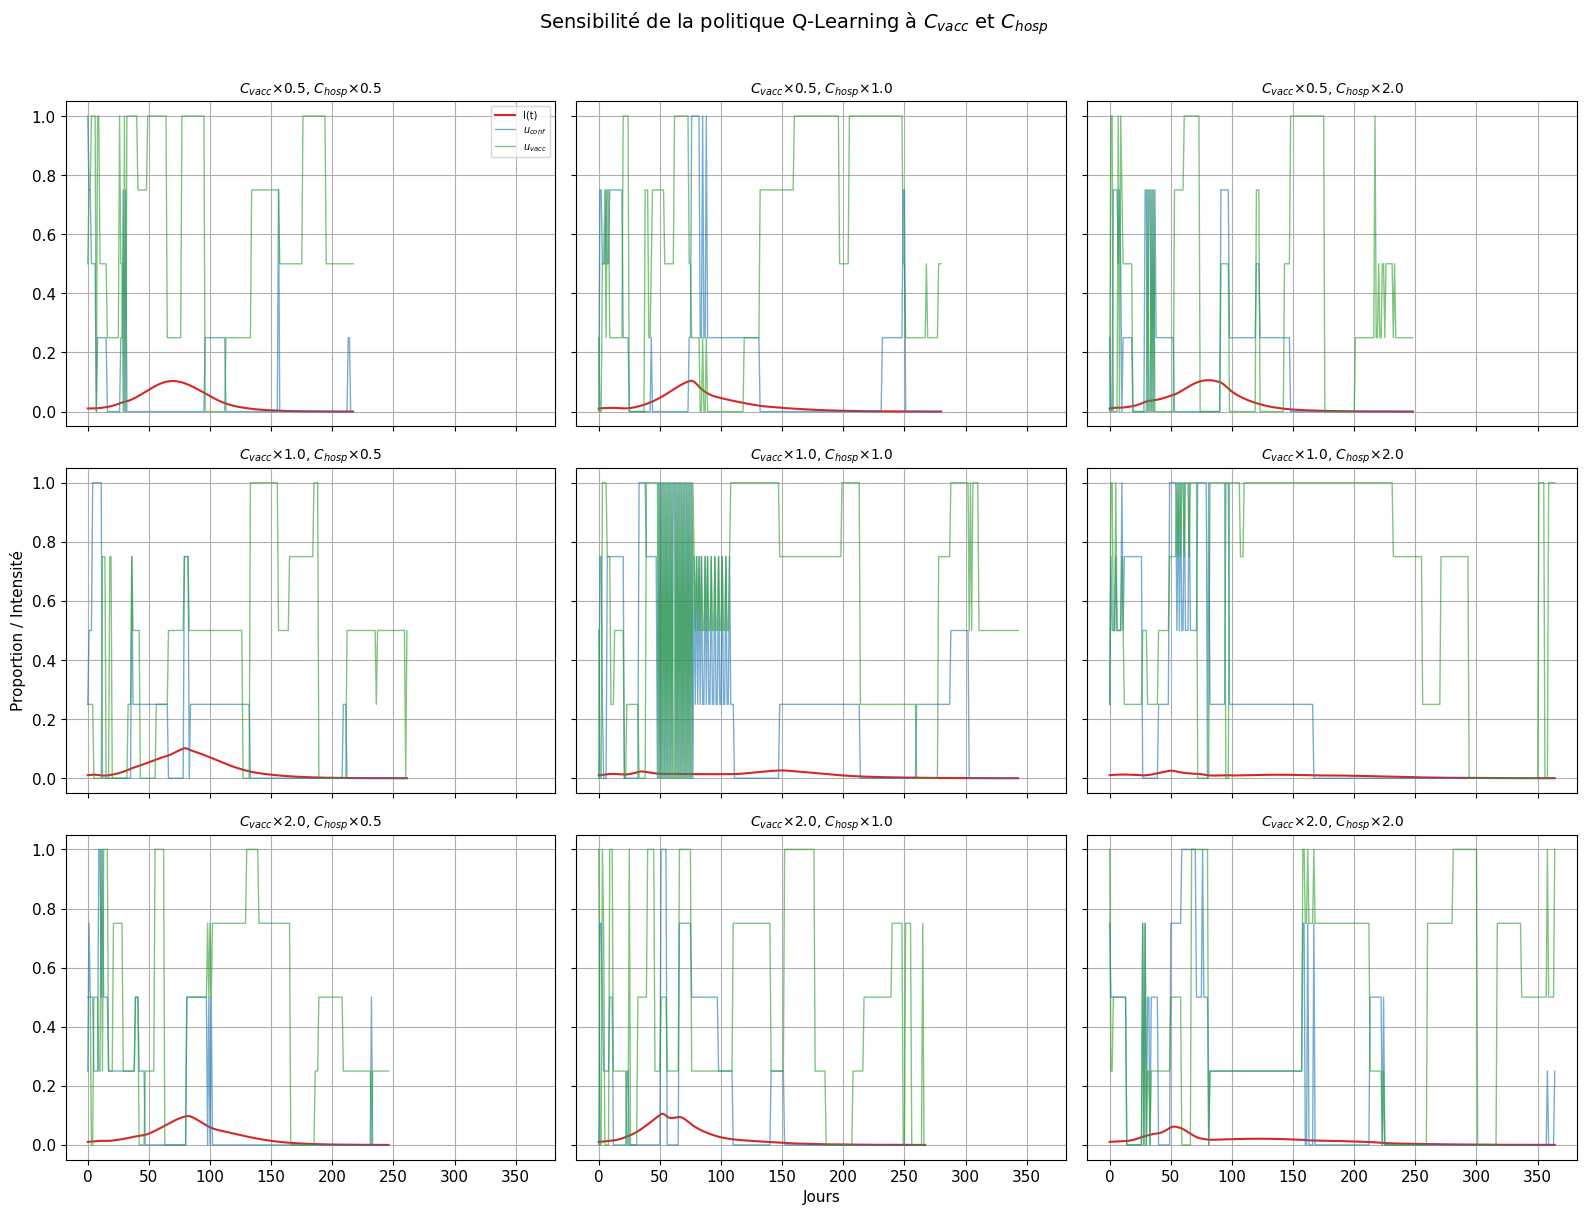

In [15]:
# ═══════════════════════════════════════════════════════════════
#  Plot : Sensibilité — Courbes I(t) et commandes
# ═══════════════════════════════════════════════════════════════

fig, axes = plt.subplots(3, 3, figsize=(16, 12), sharex=True, sharey=True)

for i, m_vacc in enumerate(multipliers):
    for j, m_hosp in enumerate(multipliers):
        ax = axes[i, j]
        label = f"C_vacc×{m_vacc}, C_hosp×{m_hosp}"
        h = sensitivity_results[label]
        days = np.arange(len(h["I"]))

        ax.plot(days, h["I"], color="tab:red", label="I(t)", linewidth=1.5)
        ax.plot(days, h["u_conf"], color="tab:blue", label="$u_{conf}$", alpha=0.6, linewidth=1)
        ax.plot(days, h["u_vacc"], color="tab:green", label="$u_{vacc}$", alpha=0.6, linewidth=1)

        ax.set_title(f"$C_{{vacc}}$×{m_vacc}, $C_{{hosp}}$×{m_hosp}", fontsize=10)
        if i == 0 and j == 0:
            ax.legend(fontsize=7)

axes[2, 1].set_xlabel("Jours")
axes[1, 0].set_ylabel("Proportion / Intensité")
fig.suptitle("Sensibilité de la politique Q-Learning à $C_{vacc}$ et $C_{hosp}$", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 9. Synthèse et discussion

**Méthodes implémentées :**
1. **Q-Learning** (off-policy, ε-greedy) — exploite le meilleur Q(s', a') futur
2. **SARSA** (on-policy, ε-greedy) — plus conservateur, tient compte de l'exploration
3. **DP approchée** (backward induction, horizon fini) — baseline optimale (en théorie)
4. **Heuristiques** — aucun contrôle, vaccination max, seuils simples/adaptatifs

**Observations attendues :**
- Le **laissez-faire** produit un pic épidémique rapide et beaucoup de décès
- La **vaccination seule** est insuffisante (0.5%/jour = trop lent face à R₀=2.7)
- Le **Q-Learning / SARSA** apprend un compromis confinement + vaccination
- La **DP approchée** sert de référence mais est limitée par la discrétisation grossière
- L'étude de sensibilité montre que ↑$C_{hosp}$ → confinement plus agressif, ↑$C_{vacc}$ → vaccination plus tardive

**Limites :**
- Discrétisation en bins → perte de précision (mais adapté au cadre tabulaire "cours")
- Pas de réseau de neurones (choix délibéré : méthodes tabulaires pures)
- Bruit très faible dans l'env → quasi-déterministe

**Références :** voir `report/projet.tex`